# biGRU RNN

## Dataset Configuration
Code taken and adjusted from the lab. We import the train and test data from the keras imdb dataset, converting it to the necessary format for the model.

In [1]:
m = 1000   # Number of words in the vocabulary
n = 20     # N most frequent words to skip
k = 0      # K least frequent words to skip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Vectorizing the text

In order to create word embeddings, we need to map each word of our vocabulary into an integer. This can be done with several approaches using Keras. We are going to use the `TextVectorization` layer.

*   We need a vocabulary size

*   We need a number which will be used as the length of the sequence that will be passed into the network. A simple heuristic: average length of the training documents

In [3]:
train_doc_length = 0
for doc in x_train:
  tokens = str(doc).split()
  train_doc_length += len(tokens)

print('\nTraining data average document length =', (train_doc_length / len(x_train)))


Training data average document length = 238.71364


In [4]:
VOCAB_SIZE = 100000
SEQ_MAX_LENGTH = 240
vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, 
                                               output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH)

with tf.device('/CPU:0'):
  vectorizer.adapt(x_train)

## Visualization Class
A few visualizations of the results. Utilizes thoroughly adjusted and optimized code from the lab and multiple libraries.
Differs from the other algorithms as it requires special handling for the RNN model.

In [5]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from seaborn import heatmap
from pandas import DataFrame
import IPython.display as ipd


def classification_data_nn(estimator, 
                          x_train, y_train,
                          x_test, y_test, 
                          epochs=1, 
                          num_layers=1,
                          emb_size=64,
                          h_size=64,
                          batch_size=64,
                          splits=5):
  
  train_accuracies, test_accuracies, train_precisions, test_precisions, train_recall, test_recall, train_f1, test_f1 = [], [], [], [], [], [], [], []
  
  split_size = int(len(x_train) / splits)
  x_splits = np.split(x_train, splits)
  y_splits = np.split(y_train, splits)
  test_cm = None
  
  for i in range(0, len(x_splits)):
    if i == 0:
      curr_x = x_splits[0]
      curr_y = y_splits[0]
    else:
      curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
      curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    
    new_estimator = estimator(num_layers=num_layers, emb_size=emb_size, h_size=h_size)
    model = new_estimator.get_model()
    est_his = model.fit(curr_x, curr_y, epochs=epochs, batch_size=batch_size)
    
    train_pred = model.predict(curr_x)
    test_pred = model.predict(x_test)
    
    train_pred = np.round(train_pred)
    test_pred = np.round(test_pred)

    train_accuracies.append(accuracy_score(curr_y, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))
    
    train_precisions.append(precision_score(curr_y, train_pred))
    test_precisions.append(precision_score(y_test, test_pred))
    
    train_recall.append(recall_score(curr_y, train_pred))
    test_recall.append(recall_score(y_test, test_pred))
    
    train_f1.append(f1_score(curr_y, train_pred))
    test_f1.append(f1_score(y_test, test_pred))


  return {'estimator': new_estimator.__name__, 
          'splits': splits,
          'split_size': split_size, 
          'test_predictions': test_pred,
          'test_predictions_cont': test_pred,
          'train_accuracy': train_accuracies, 
          'test_accuracy': test_accuracies, 
          'train_precision': train_precisions, 
          'test_precision': test_precisions, 
          'train_recall': train_recall, 
          'test_recall': test_recall, 
          'train_f1': train_f1, 
          'test_f1': test_f1,
          }

def classification_data(estimator, 
                          x_train, y_train,
                          x_test, y_test,
                          splits = 5):
  train_accuracies, test_accuracies, train_precisions, test_precisions, train_recall, test_recall, train_f1, test_f1 = [], [], [], [], [], [], [], []
  
  # Split the training data into n splits
  split_size = int(len(x_train) / splits)
  x_splits = np.split(x_train, splits)
  y_splits = np.split(y_train, splits)
  
  # Train the model on each split and evaluate on the test set
  for i in range(0, len(x_splits)):
    if i == 0:
      curr_x = x_splits[0]
      curr_y = y_splits[0]
    else:
      curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
      curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    
    # Train the model and get train/test predictions
    estimator.fit(curr_x, curr_y)
    train_pred = estimator.predict(curr_x)
    test_pred = estimator.predict(x_test)
    
    # Calculate and save the necessary metrics for this train/test split
    train_accuracies.append(accuracy_score(curr_y, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))
    
    train_precisions.append(precision_score(curr_y, train_pred))
    test_precisions.append(precision_score(y_test, test_pred))
    
    train_recall.append(recall_score(curr_y, train_pred))
    test_recall.append(recall_score(y_test, test_pred))
    
    train_f1.append(f1_score(curr_y, train_pred))
    test_f1.append(f1_score(y_test, test_pred))

  
  # Results required for all the future plots/tables
  return {'estimator': estimator.__class__.__name__, 
          'split_size': split_size, 
          'splits': splits,
          'test_predictions': test_pred,
          'train_accuracy': train_accuracies, 
          'test_accuracy': test_accuracies, 
          'train_precision': train_precisions, 
          'test_precision': test_precisions, 
          'train_recall': train_recall, 
          'test_recall': test_recall, 
          'train_f1': train_f1, 
          'test_f1': test_f1}
  
def classification_plots(classification_data, full_scale=False):
  split_size = classification_data['split_size']
  splits = classification_data['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve for {estimator}".format(estimator=classification_data['estimator']), fontsize=16)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training")
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing")
      axis[i, j].grid(alpha = 0.3)  
  
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
 
  return figure


def classification_table(classification_data):
  split_size = classification_data['split_size']
  df = DataFrame(data={'Train Accuracy': np.round(classification_data['train_accuracy'], 2), 
                         'Test Accuracy': np.round(classification_data['test_accuracy'], 2), 
                         'Precision Train' : np.round(classification_data['train_precision'], 2), 
                         'Precision Test' : np.round(classification_data['test_precision'], 2), 
                         'Recall Train' : np.round(classification_data['train_recall'], 2), 
                         'Recall Test' : np.round(classification_data['test_recall'], 2), 
                         'F1 Train' : np.round(classification_data['train_f1'], 2), 
                         'F1 Test' : np.round(classification_data['test_f1'], 2)}, 
                   index=list(range(split_size, len(x_train) + split_size, split_size)))
  return df

def classification_plots_compare(classification_data_x, classification_data_y, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure for both classifiers.
  
  Arguments:
    classification_data_x: The dictionary containing the train/test data for the first classifier.
    classification_data_y: The dictionary containing the train/test data for the second classifier.
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores 
    for both classifiers.
  """
  
  split_size = classification_data_x['split_size']
  splits = classification_data_x['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve Comparison for {estimator} against {estimator_2} ".format(estimator=classification_data_x['estimator'], estimator_2=classification_data_y['estimator']), fontsize=12)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#AD49C2", label="Training {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#7CC249", label="Testing {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].grid(alpha = 0.3) 
    
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
  return figure


def roc_curve_plot(y_pred_cont, name):
  fpr, tpr, _ = roc_curve(y_test, y_pred_cont)
  roc_auc = auc(fpr, tpr)

  figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
  axis.plot(fpr, tpr, color='#2c8dc9', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  axis.plot([0, 1], [0, 1], color='#FFAD00', lw=2, linestyle='--', label='No Skill')
  axis.set_xlim([0.0, 1.0])
  axis.set_ylim([0.0, 1.05])
  axis.set_xlabel('False Positive Rate')
  axis.set_ylabel('True Positive Rate')
  axis.set_title('Receiver operating characteristic for {estimator}'.format(estimator=name))
  axis.legend(loc="lower right")
  axis.grid(alpha = 0.3)

  return figure

def loss_plot(loss, val_loss, name):
  figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
  epochs = range(1, len(loss)+1)
  axis.plot(epochs, loss, color='#2c8dc9', lw=2, label='Loss')
  axis.plot(epochs, val_loss, color='#FFAD00', lw=2, label='Validation Loss')
  axis.set_xlabel('Epoch')
  axis.set_ylabel('Loss')
  axis.set_title('Loss over Epochs for {estimator}'.format(estimator=name))
  axis.legend(loc="upper right")
  axis.grid(alpha = 0.3)

  return figure


## biGRU RNN Model
A class that implenets our custom biGRU RNN model as specified in the lab. It is a simple model with a few layers and a few hyperparameters.

In [6]:
class bigru_rnn():
    
    def __init__(self, num_layers=1, emb_size=64, h_size=64):
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.h_size = h_size
        
        inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
        x = vectorizer(inputs)
        x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                        output_dim=self.emb_size, name='word_embeddings',
                                        mask_zero=True)(x)
        
        for n in range(self.num_layers):
            if n != self.num_layers - 1:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                    name=f'bigru_cell_{n}', 
                                    return_sequences=True,
                                    dropout=0.2))(x)
            else:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                                name=f'bigru_cell_{n}',
                                                dropout=0.2))(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
         
        o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
        
        self.model = tf.keras.models.Model(inputs=inputs, outputs=o, name='biGRU_RNN')
        self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy())

    def __name__(self):
        return 'biGRU RNN'
    
    def fit(self, x_train, y_train, epochs=1, batch_size=64, validation_split=0):
        self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    
    def get_model(self):
        return self.model
      

In [7]:
loss_rnn = bigru_rnn(num_layers=1, emb_size=64, h_size=64)
model = loss_rnn.get_model()
print(model.summary())

Model: "biGRU_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 txt_input (InputLayer)      [(None, 1)]               0         
                                                                 
 vector_text (TextVectorizat  (None, 240)              0         
 ion)                                                            
                                                                 
 word_embeddings (Embedding)  (None, 240, 64)          62720     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 lr (Dense)                  (None, 1)                 12

## biGRU RNN Results and Comparison
The biGRU RNN is tested on the test data and the results are visualized. The results are compared to the results of our implementations of the other algorithms.

### Loss over epochs and ROC Curve
We calculate the loss over epochs and plot it. We also calculate the ROC curve and plot it.

In [8]:
rnn_hist = model.fit(x_train, y_train, epochs=6, batch_size=64, validation_split=0.2)
rnn_pred = model.predict(x_test)

Epoch 1/6
313/313 [==============================] - 29s 83ms/step - loss: 0.5950 - val_loss: 0.3952
Epoch 2/6
313/313 [==============================] - 25s 81ms/step - loss: 0.3782 - val_loss: 0.3957
Epoch 3/6
313/313 [==============================] - 25s 80ms/step - loss: 0.3451 - val_loss: 0.3590
Epoch 4/6
313/313 [==============================] - 26s 84ms/step - loss: 0.3294 - val_loss: 0.3555
Epoch 5/6
313/313 [==============================] - 25s 79ms/step - loss: 0.3139 - val_loss: 0.3597
Epoch 6/6
782/782 [==============================] - 12s 14ms/step


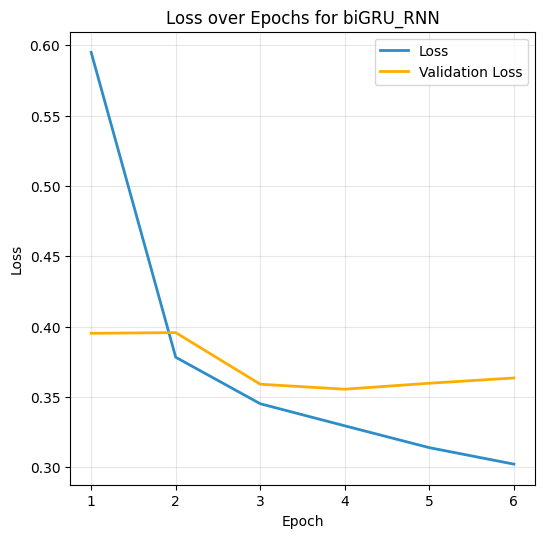

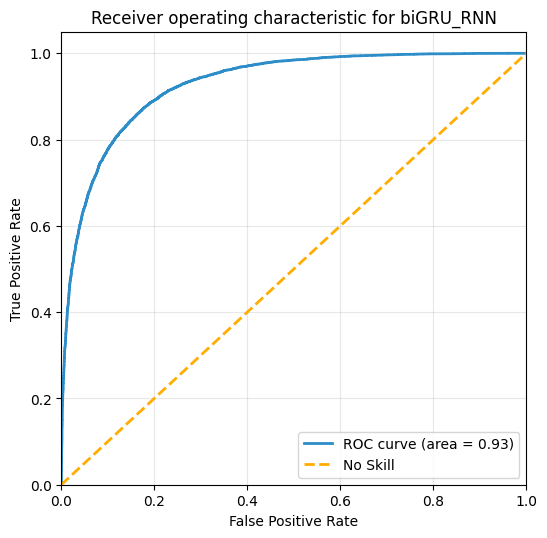

In [9]:
rnn_ls_plt = loss_plot(rnn_hist.history['loss'], rnn_hist.history['val_loss'], model.name)
rnn_auc_plt = roc_curve_plot(rnn_pred, model.name)

# from tensorflow.keras.utils import plot_model
# from IPython.display import Image 
# plot_model(model, to_file='model.png', show_shapes=True)
# Image('model.png')

### Classification Data for the biGRU RNN
We calculate the classification data for the biGRU RNN and plot it.

In [10]:
rnn_cd = classification_data_nn(bigru_rnn, x_train, y_train, x_test, y_test, num_layers=1, epochs=6, batch_size=64, splits=5)
rnn_cd['estimator'] = 'biGRU RNN'

Epoch 1/6
79/79 [==============================] - 11s 101ms/step - loss: 0.6895
Epoch 2/6
79/79 [==============================] - 8s 100ms/step - loss: 0.6996
Epoch 3/6
79/79 [==============================] - 8s 102ms/step - loss: 0.5780
Epoch 4/6
79/79 [==============================] - 8s 102ms/step - loss: 0.4540
Epoch 5/6
79/79 [==============================] - 8s 103ms/step - loss: 0.3764
Epoch 6/6
782/782 [==============================] - 15s 19ms/step
Epoch 1/6
157/157 [==============================] - 17s 91ms/step - loss: 0.6480
Epoch 2/6
157/157 [==============================] - 15s 93ms/step - loss: 0.4079
Epoch 3/6
157/157 [==============================] - 14s 90ms/step - loss: 0.3423
Epoch 4/6
157/157 [==============================] - 14s 90ms/step - loss: 0.3175
Epoch 5/6
157/157 [==============================] - 14s 90ms/step - loss: 0.3016
Epoch 6/6
782/782 [==============================] - 10s 13ms/step
Epoch 1/6
235/235 [==============================] - 64

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.88,0.80,0.91,0.83,0.85,0.76,0.88,0.79
10000,0.90,0.83,0.88,0.81,0.93,0.86,0.90,0.83
15000,0.89,0.84,0.85,0.81,0.93,0.89,0.89,0.85
20000,0.90,0.85,0.88,0.84,0.92,0.87,0.90,0.86
25000,0.90,0.85,0.90,0.86,0.89,0.85,0.90,0.85


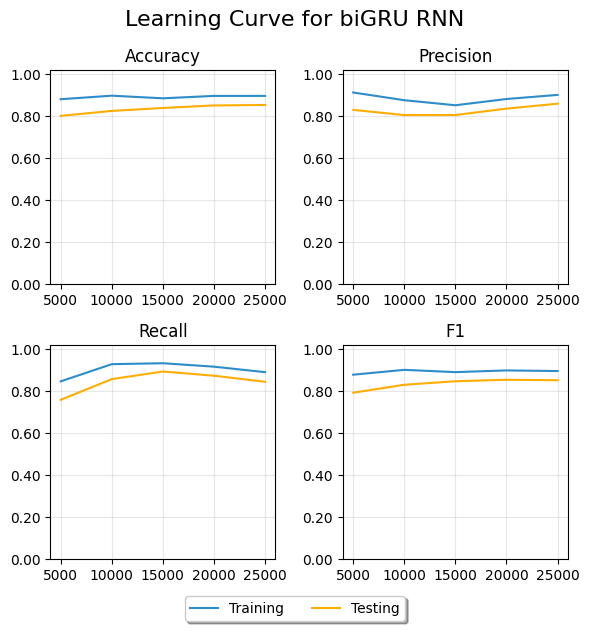

In [11]:
rnn_cf_plt = classification_plots(rnn_cd, True)
rnn_cf_tbl = classification_table(rnn_cd)
ipd.display(rnn_cf_tbl)

### Binary Vector Creation
Converts the dataset data into a binary vector, where each word is represented by a 1 or 0. 1 if the word is present in the review, 0 if it is not.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())

### biGRU RNN against our Bernoulli Naive Bayes Implementation
The biGRU RNN is tested against the Bernoulli Naive Bayes Classifier we implemented. The results are visualized and analyzed.


#### Bernoulli Naive Bayes Implementation

In [13]:
class BernoulliNaiveBayes:
  
  def __init__(self):
    pass 

  def fit(self, X, y):
    # Calculate the a-priori (log) probability for each class
    self.p_log_pos = np.log(np.sum(y) / len(y))
    self.p_log_neg = np.log(1 - np.sum(y) / len(y))
    
    # Calculate the (log) probability of each set of features given each class (y = 1 (Good) or y = 0 (Bad))
    # p(feature|class) = (np.sum(X[y == class], axis=0) + 1) / (np.sum(y) + 2)
    self.p_log_pos_feature1 = np.log((np.sum(X[y == 1], axis=0) + 1) / (np.sum(y) + 2))
    self.p_log_neg_feature1 = np.log((np.sum(X[y == 0], axis=0) + 1) / (len(y) - np.sum(y) + 2))
    self.p_log_pos_feature0 = np.log(1.0 - (np.sum(X[y == 1], axis=0) + 1) / (np.sum(y) + 2))
    self.p_log_neg_feature0 = np.log(1.0 - (np.sum(X[y == 0], axis=0) + 1) / (len(y) - np.sum(y) + 2))
    
    
  def predict(self, X):
    X_reverse = np.where((X==0)|(X==1), X^1, X)
    p_log_pos = X_reverse.dot(self.p_log_pos_feature0) + X.dot(self.p_log_pos_feature1) + self.p_log_pos
    p_log_neg = X_reverse.dot(self.p_log_neg_feature0) + X.dot(self.p_log_neg_feature1) + self.p_log_neg
    
    return np.array([1 if p_log_pos[i] > p_log_neg[i] else 0 for i in range(len(X))])

#### Comparison

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.050000,-0.020000,0.090000,0.020000,0.000000,-0.080000,0.040000,-0.040000
10000,0.080000,0.010000,0.070000,0.010000,0.070000,0.020000,0.070000,0.010000
15000,0.070000,0.020000,0.040000,0.010000,0.080000,0.050000,0.060000,0.030000
20000,0.080000,0.030000,0.070000,0.030000,0.070000,0.030000,0.070000,0.030000
25000,0.080000,0.040000,0.100000,0.060000,0.040000,0.010000,0.080000,0.030000


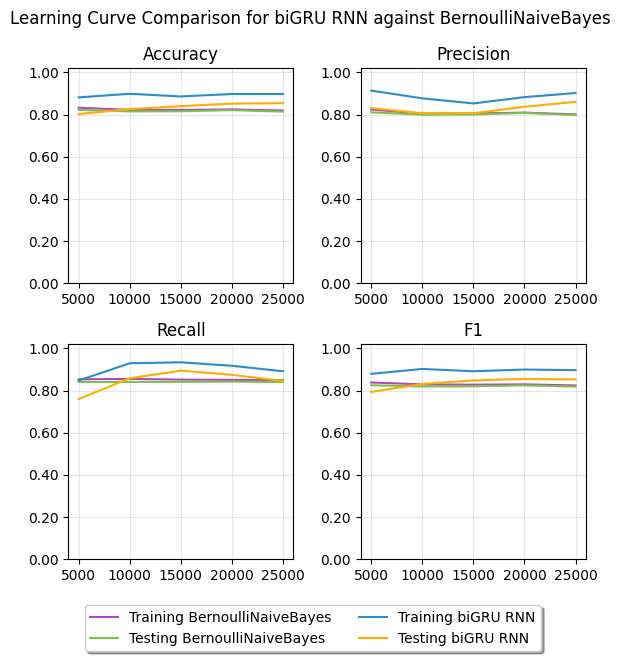

In [14]:
bnb_data = classification_data(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)
bnb_cf_tbl = classification_table(bnb_data)

bigru_bnb_tbl = rnn_cf_tbl - bnb_cf_tbl
bigru_bnb_tbl = bigru_bnb_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=rnn_cd['estimator'], estimator_2=bnb_data['estimator']))
ipd.display(bigru_bnb_tbl)
bigru_bnb_tplt = classification_plots_compare(rnn_cd, bnb_data, True)

### biGRU RNN against our ID3 Implementation
The biGRU RNN is tested against the ID3 Classifier we implemented. The results are visualized and analyzed.

#### ID3 Implementation

In [17]:
import random
from math import log

# if node is parent node , it will have: 1)the feature with the maximum Information Gain 2)right child 3)left child (each child can be either a subtree or a leaf)
# if node is leaf it will only have the pred which is the decision either good or bad (1 or 0)
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = -1 
        self.pred = -1


class ID3:

    def __init__(self,maxDepth):
        self.root = Node()
        self.maxDepth = maxDepth

    def IG(self,class_, feature):
        classes = set(class_)
        feature_values = set(feature)
        Hc = 0
        for c in classes:
            pc = list(class_).count(c)/len(class_)
            Hc += - pc * log(pc, 2)
        Hc_feature = 0
        for feat in feature_values:
            #pf --> P(X=x)
            pf = list(feature).count(feat)/len(feature)
            indices = [i for i in range(len(feature)) if feature[i] == feat] 
            clasess_of_feat = [class_[i] for i in indices] 
            for c in classes: #c=0,1
                #pcf --> P(C=c|X=x)
                pcf = clasess_of_feat.count(c)/len(clasess_of_feat) 
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * log(pcf, 2)
                    #sum for all values of C (class) and X (values of specific feature)
                    Hc_feature += temp_H
        ig = Hc - Hc_feature
        return ig 


    def ID3_TREE(self,X,y,list_features,depth):
    
        root = Node()
        left_y = list() 
        right_y = list()
        left_subdata = list()
        right_subdata= list()
        X_new = np.array(X)
        max_IG = -1
        feature_max_IG = -1
        
        # finds the feature with the maximum Information Gain
        for i in range(len(X[0])):
            feat_ig = self.IG(y,X_new[:,i])
            if max_IG < feat_ig:
                max_IG = feat_ig
                local_indexofFeature_maxIG = i
                feature_max_IG = list_features[i]
        root.feature = feature_max_IG
        # delete the feature with the maximum IG from the feature list
        list_features_del = np.delete(list_features,local_indexofFeature_maxIG)
        # delete the row from array X_new which has the feature with the maximum IG
        X_new = np.delete(X_new,local_indexofFeature_maxIG,1) 

        # split the data in two lists
        # for each example if the feature with the maximum IG == 0 append this example in list0 and in y_new0 append the classification (Good(1) or Bad(0)) of this example
        # else if the feature with the maximum IG == 1  append this example in list1 and in y_new1 append the classification (Good(1) or Bad(0)) of this example
        for i in range(len(X)): 
            if X[i][local_indexofFeature_maxIG]== 0:  
                left_y.append(y[i]) 
                left_subdata.append(X_new[i])
            else: 
                right_y.append(y[i])
                right_subdata.append(X_new[i])  
        
        subdata_X = [left_subdata,right_subdata] 
        subdata_y = [left_y,right_y]
         
        #this loop create the left and right child of Node root 
        for i in range(2): 
            sum_of_positive_examples= np.sum(subdata_y[i])
            # if the percentage of positive(1) examples is greater than 80% or the percentage of negative(0) examples is greater than 80% or we reach in maxdepth
            #  then create leaf and take decision (positive or negative example) 
            if sum_of_positive_examples>=0.8*len(subdata_y[i]) or sum_of_positive_examples<0.2*len(subdata_y[i]) or  depth==self.maxDepth:
                new_Node = Node()
                if (depth==self.maxDepth):
                    if(sum_of_positive_examples>(len(subdata_y[i])/2)):
                        new_Node.pred = 1
                    elif sum_of_positive_examples<(len(subdata_y[i])/2):
                        new_Node.pred = 0      
                    else:
                        new_Node.pred = random.randint(0, 1)      
                else:
                    if(sum_of_positive_examples>=0.8*len(subdata_y[i])):    
                        new_Node.pred = 1 
                    else:
                        new_Node.pred = 0 

                if i==0 :
                    root.left = new_Node   
                else:
                    root.right = new_Node   
            else:
                #when i == 0 create the left subtree, when i == 1 create the right subtree
                child = self.ID3_TREE(subdata_X[i], subdata_y[i],list_features_del,depth+1)
                if i==0 :
                    root.left = child   
                else:
                    root.right = child
        return root 

    def fit(self, X, y):
        list_features =np.arange(len(X[0]))
        self.root = self.ID3_TREE(X, y, list_features, 0)
        
    def predict(self, X): 
        root=Node()
        y_pred = list()
        for example in X:
            root = self.root
            for i in range(len(example)):
                if root.left == None and root.right == None:
                    y_pred.append(int(root.pred))
                    break
                if example[root.feature] == 0:
                    root = root.left
                else:
                    root = root.right            
               
        return y_pred  

#### Comparison

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.120000,0.080000,0.190000,0.150000,-0.020000,-0.070000,0.090000,0.040000
10000,0.160000,0.120000,0.160000,0.120000,0.150000,0.090000,0.150000,0.100000
15000,0.140000,0.110000,0.140000,0.120000,0.080000,0.060000,0.120000,0.090000
20000,0.150000,0.120000,0.170000,0.150000,0.060000,0.030000,0.120000,0.100000
25000,0.160000,0.130000,0.180000,0.160000,0.100000,0.080000,0.150000,0.110000


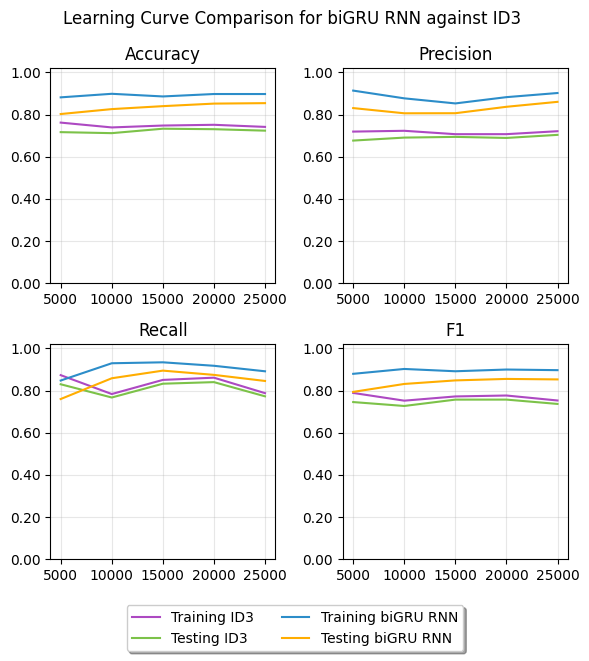

In [18]:
id3_data = classification_data(ID3(10), x_train_binary, y_train, x_test_binary, y_test, 5)
id3_cf_tbl = classification_table(id3_data)

bigru_id3_tbl = rnn_cf_tbl - id3_cf_tbl
bigru_id3_tbl = bigru_id3_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=rnn_cd['estimator'], estimator_2=id3_data['estimator']))
ipd.display(bigru_id3_tbl)

bigru_id3_tplt = classification_plots_compare(rnn_cd, id3_data, True)

### biGRU RNN against our Logistic Regression Implementation
The biGRU RNN is tested against the Logistic Regression Classifier we implemented. The results are visualized and analyzed.

#### Logistic Regression Implementation

In [19]:
from sklearn.utils import shuffle
from math import log

# Logistic Regression for binary classification
class LogisticRegression:
  def __init__(self, lamda_value=0.001, max_epochs=1000):
    self.weights = None
    self.eta = 0.01
    self.lamda = lamda_value
    self.max_epochs = max_epochs
    self.tolerance = 1e-3
    self.max_no_improvement = 5
  

  def predict(self, X):
    y_pred = list()

    # add a feature equal to 1 for the bias term at the beginning of every example feature vector
    X = np.insert(X, 0, 1, axis=1)

    # for each example vector, if its dot product with the weight vector is greater than 0
    # the algorithms predicts this example to be positive, else it predicts it to be negative
    for x in X:
      y_pred.append(1 if np.dot(self.weights, x) > 0.0 else 0)

    return y_pred
    

  # computes the logistic function using the dot product 
  # of the given example vector and the current weights as argument
  def prob_pos(self, x):
    return 1.0 / (1.0 + np.exp(-np.dot(x, self.weights)))
    

  def fit(self, X, y):    
    
    # add a feature equal to 1 for the bias term at the beginning of every example feature vector
    X = np.insert(X, 0, 1, axis=1)

    examples_num = X.shape[0]
    features_num = X.shape[1]

    # initialize weight array (including bias) with 0s
    self.weights = np.zeros(features_num)    

    # initialize no_improvement counter
    no_improvement = 0   

    # initialize the minimum loss to its maximum value, 1
    min_loss = 1

    # SGD
    # keep running epochs, until you reach the maximum number of epochs or the stopping condition
    for epoch in range(self.max_epochs):

      # shuffle the training example array and the corresponding category array in unison
      # (the index of each example and its category retain the same index in the training and the category array) 
      X, y = shuffle(X, y, random_state=0)

      # initialize the loss for the current epoch at 0
      loss = 0.0

      # go through every example in the training data
      for i in range(examples_num):
        
        # compute the probability of the current example belonging to the positive category
        prob_pos = self.prob_pos(X[i])

        # update weights using the gradient of the loss function and regularization
        self.weights = (1 - 2 * self.lamda * self.eta) * self.weights + self.eta * (y[i] - prob_pos) * X[i]

        # compute the logarithms necessary for computing the loss function
        # in case of zero probility, make it an extremely small value, so that its logarithm can be computed
        if (prob_pos == 0.0):
          prob_pos = 1e-300
        log_prob_pos = log(prob_pos)

        prob_neg = 1.0 - prob_pos       
        if (prob_neg == 0.0):
          prob_neg = 1e-300
        log_prob_neg = log(prob_neg)
        
        # increment the loss function with the (negative of the) log probability 
        # of the current example being classified in the correct category
        loss -= y[i] * log_prob_pos + (1-y[i]) * log_prob_neg

      # normalize loss by dividing with the number of examples
      loss /= examples_num

      # if current loss is below threshold, increment the no_improvement counter
      if loss > min_loss + self.tolerance:
        no_improvement += 1

      # if the current loss is less than the min_loss, reset the no_improvement counter
      # and make current loss the min_loss
      if loss < min_loss:
        no_improvement = 0
        min_loss = loss

      # if the no_improvement counter reached its maximum value, stop running fit()
      if no_improvement == self.max_no_improvement:
        print("Number of training examples =", len(X), ":: Converged at epoch", epoch+1, ":: Loss =", min_loss)
        break

#### Comparison

Number of training examples = 5000 :: Converged at epoch 25 :: Loss = 0.2835949953013422
Number of training examples = 10000 :: Converged at epoch 23 :: Loss = 0.32139764678945143
Number of training examples = 15000 :: Converged at epoch 32 :: Loss = 0.33583711547167866
Number of training examples = 20000 :: Converged at epoch 20 :: Loss = 0.34277475103648897
Number of training examples = 25000 :: Converged at epoch 41 :: Loss = 0.34504028570728595


,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.020000,-0.030000,-0.010000,-0.030000,-0.020000,-0.040000,-0.020000,-0.040000
10000,0.020000,-0.020000,0.000000,-0.040000,0.040000,0.010000,0.010000,-0.020000
15000,0.020000,-0.010000,-0.020000,-0.040000,0.060000,0.040000,0.020000,0.000000
20000,0.040000,0.000000,0.040000,0.020000,0.020000,-0.020000,0.030000,0.000000
25000,0.050000,0.010000,0.090000,0.060000,-0.030000,-0.060000,0.040000,0.000000


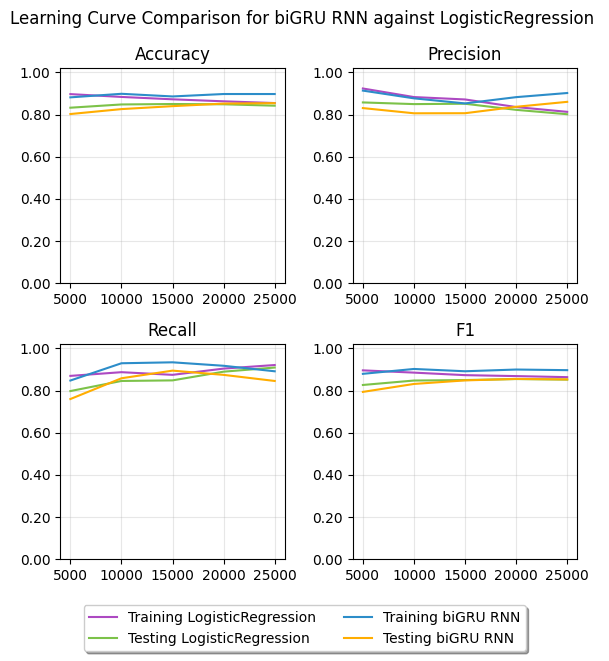

In [20]:
lgr_data = classification_data(LogisticRegression(), x_train_binary, y_train, x_test_binary, y_test, 5)
lgr_cf_tbl = classification_table(lgr_data)

bigru_lgr_tbl = rnn_cf_tbl - lgr_cf_tbl
bigru_lgr_tbl = bigru_lgr_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=rnn_cd['estimator'], estimator_2=lgr_data['estimator']))
ipd.display(bigru_lgr_tbl)

bigru_lgr_tplt = classification_plots_compare(rnn_cd, lgr_data, True)